In [1]:
import sys
sys.path.append("../..")
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import os
import seaborn as sns
import networkx as nx
from sys import platform 
from src.eda.subset_network import subset_network
from src.eda.eda_functions import *
from src.eda.process_phenotype import *
from src.embedding.network_embedding import network_embedding
from sklearn.model_selection import train_test_split
from harness.test_harness_class import TestHarness
from harness.utils.parsing_results import *
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.rocklin_models import logistic_classifier
from harness.th_model_instances.perovskite_models.xgboost import gradient_boosted_tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
os.chdir('C:/Users/bbche/Documents/GitRepos/assist/data/embedding_Dec1')
emb_dfs = []
# kmeans_list = []
for file in os.listdir():
    emb = pd.read_csv(file, index_col = 0)
    emb_dfs.append(emb)
#     kmeans_list.append(run_kmeans(emb, 2))

In [10]:
os.listdir()

['embedded_len16_walk100_cluster3+4.csv',
 'embedded_len16_walk300_cluster3+4.csv',
 'embedded_len64_walk100_cluster3+4.csv',
 'embedded_len64_walk300_cluster3+4.csv']

In [5]:
deseq = pd.read_excel('G:/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')
deseq['abs_log2FC'] = abs(deseq['log2FoldChange'])

In [6]:
def process_emb_for_ML(embedding_df, deseq = deseq):
    embedding_labeled_df = pd.merge(embedding_df, deseq, left_index = True, right_on = 'id')
    embedding_labeled_df['impact'] = 1
    embedding_labeled_df.loc[embedding_labeled_df['log2FoldChange'].between(-0.1, 0.1), 'impact'] = 0
    return embedding_labeled_df

In [ ]:
# Find important embedding space identified by different models

In [7]:
processed_emb_dfs = list(map(process_emb_for_ML, emb_dfs))

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [30]:
lr = LogisticRegression(max_iter = 1000)
rf = RandomForestClassifier()
xgb = XGBClassifier()

In [33]:
embedding_df = processed_emb_dfs[0]
num_sample = embedding_df.impact.value_counts().min()
emb_subset = embedding_df.groupby('impact').sample(num_sample).reset_index() # subset to have equal samples in the two classes
X_train, X_test, y_train, y_test = train_test_split(emb_subset.iloc[:, :64], emb_subset['impact'], test_size = 0.2)
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
print('lr accuracy', lr.score(X_test, y_test))
print('rf accuracy', rf.score(X_test, y_test))
xgb_predict = xgb.predict(X_test)
print('xgb accuracy', accuracy_score(y_test, xgb_predict))

lr accuracy 0.6580310880829016
rf accuracy 0.689119170984456
xgb accuracy 0.6632124352331606


In [51]:
lr_coef = lr.coef_[0]
rf_coef = rf.feature_importances_
xgb_coef = xgb.feature_importances_

In [96]:
# lr requires taking absolute value and dividing the sum to get % of importance for each feature
lr_coef = np.abs(lr_coef)
lr_coef /= np.sum(lr_coef)

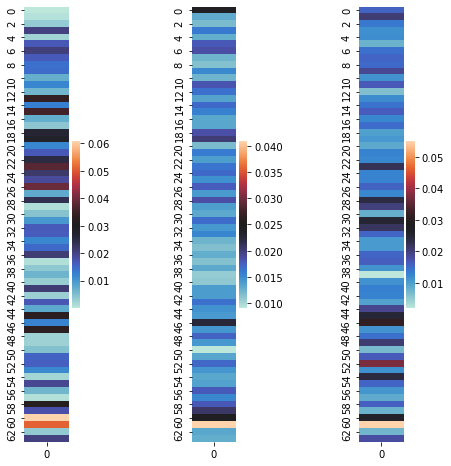

In [99]:
plt.figure(figsize = (7, 8))
plt.subplot(1,3,1)
sns.heatmap(lr_coef.reshape(64, 1), center = np.mean([lr_coef.min(), lr_coef.max()]),
            vmin = lr_coef.min(), vmax = lr_coef.max())
plt.subplot(1,3,2)
sns.heatmap(rf_coef.reshape(64, 1), center = np.mean([rf_coef.min(), rf_coef.max()]), 
            vmin = rf_coef.min(), vmax = rf_coef.max())
plt.subplot(1,3,3)
sns.heatmap(xgb_coef.reshape(64, 1), center = np.mean([xgb_coef.min(), xgb_coef.max()]), 
            vmin = xgb_coef.min(), vmax = xgb_coef.max())
plt.subplots_adjust(wspace = 2)

In [107]:
# Determine percentage of feature importance preserved from using top n features
np.sum(lr_coef[lr_coef.argsort()[-5:]])

0.22485964871236178

In [106]:
np.sum(rf_coef[rf_coef.argsort()[-8:]])

0.19065231496704665

In [105]:
np.sum(xgb_coef[xgb_coef.argsort()[-6:]])

0.20070519